<center>
<img align ="left" src="hacettepe.png" alt="Hacettepe University Logo" width="200\">
<br><h1>HACETTEPE UNIVERSITY</h1>
<h1>ELE492 : Image Processing | HW-2</h1>
<h2>Ayşe İdman - 21728366</h2>
</center>

___

### Q1)
<br>


<pre>I pledge that I have not received or given any aid in this homework. 
All the work presented below is my own work.
                
                                                             <b>Ayşe İdman 
                                                                21728366</b>
</pre>
<img align ="right" src="signature.png" alt="Hacettepe University Logo" width="250">

___

___

___

### Q4)

(-0.5, 799.5, 532.5, -0.5)

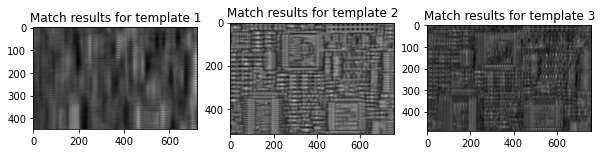

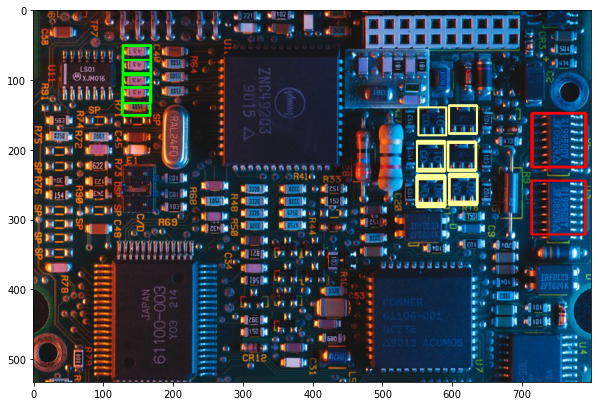

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread("HW2images/fullImage.jpg")
image = image[...,::-1].copy() #convert bgr to rgb
image_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

#reading the templates and convert them bgr to rgb
templates = [cv2.imread("HW2images/component" +str(i)+ ".jpg")[...,::-1] for i in range(1,4)]
#resizing the templates
templates[0] = cv2.resize(templates[0], dsize=(77,87))
templates[1] = cv2.resize(templates[1], dsize=(40,18))
templates[2] = cv2.resize(templates[2], dsize=(40,44))

matches_list = []
fig = plt.figure(figsize=(10,7)) 
for i in range(3):
    matches = cv2.matchTemplate(image,templates[i],cv2.TM_CCOEFF_NORMED)
    matches_list.append(matches)
    fig.add_subplot(1, 3, i+1)
    plt.title("Match results for template " + str(i+1))
    plt.imshow(matches, cmap = "gray") 
    plt.axis('on') 
    
locations_list = [] # all of the locations for templates (1,2,3) that greater than threshold  
result = image.copy()
#dimensions of temlates respectively (w,h)
dimensions = [(77,87),(40,18),(40,44)]
#colors of the rectangles for templates
colors = [(255, 0, 0),(0, 255, 0),(255,255,153)]
#thresholds for all three templates
thresholds = [0.78,0.8,0.58]

for threshold,dimension,color,matches in zip(thresholds,dimensions,colors,matches_list):

    locations = np.where(matches >= threshold)
    for (x, y) in zip(locations[1], locations[0]):
        cv2.rectangle(result,(x,y),(x+dimension[0],y+dimension[0]),color,2)

    locations_list.append(locations)    

fig2 = plt.figure(figsize=(10,7))
plt.imshow(result) 
plt.axis("on")    



___

___

### Q4) IOU Correction

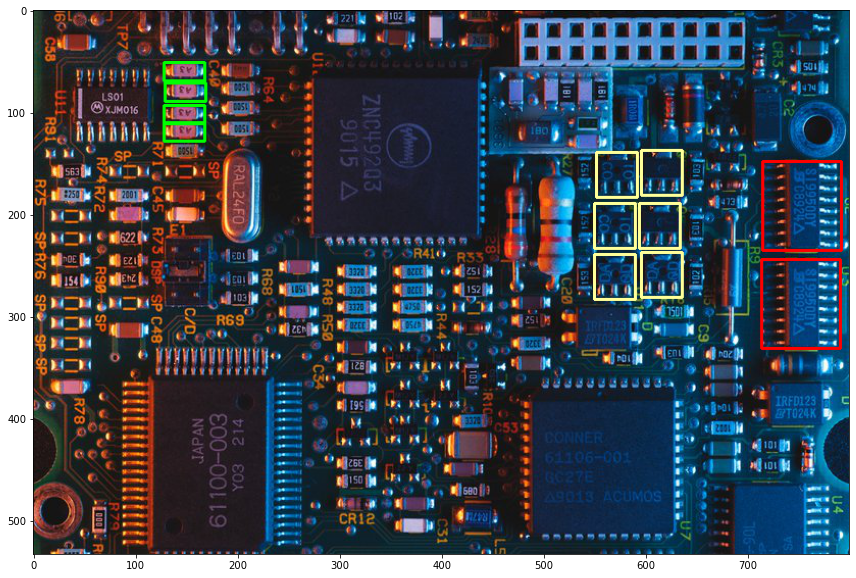

In [2]:
corr_result = image.copy() #corrected result by applying iou method (eliminating multiple windows)
iou_th = 0.5 #selected iou threshold

for locations,dimension,color,matches,threshold in zip(locations_list,dimensions,colors,matches_list,thresholds):
    #top-left corners
    y1 = np.array(locations[0])
    x1 = np.array(locations[1])
    #bottom-right corners
    x2 = x1 + dimension[0]
    y2 = y1 + dimension[1]

    #finding the values of similarity scores (which are greater than threshold) by using their indexes in the matches_list
    scores = matches
    scores = scores[scores > threshold]
    #sorting the scores with the indexes to make sure that the first valid window has the biggest score
    scores_sorted_idxs =np.argsort(scores)[::-1] 
    valid_windows = []
    for i in scores_sorted_idxs:
        overlapped = False
        for j in valid_windows:
            #coordinates of the intersection area
            inter_x1 = max(x1[i],x1[j])
            inter_y1 = max(y1[i],y1[j])
            inter_x2 = min(x2[i],x2[j])
            inter_y2 = min(y2[i],y2[j])

            inter_width = inter_x2-inter_x1
            inter_height = inter_y2-inter_y1

            if not(inter_width <= 0 or inter_height <= 0):
                #iou calculation
                overlapped_area = inter_width*inter_height
                iou = overlapped_area / (2*dimension[0]*dimension[1]-overlapped_area)
                if iou > iou_th :
                    overlapped = True

        if not overlapped: #if there is no overlap, the window is valid
            valid_windows.append(i)   
            
            
    for index in valid_windows:
        cv2.rectangle(corr_result,(x1[index],y1[index]),(x2[index],y2[index]),color,2)
    
        
fig3 = plt.figure(figsize=(20,10))    
plt.imshow(corr_result)
plt.show()
    

By looking at the result, we can see the previous result needs enhancement. With the quideline given in the homework, I implemented this enhancement with iou calculation. In the previous result, my code did detect the components but unfortunately number of windows was more than it should be. So, I added an extra correction in order to eliminate these unnecessary windows. As you can see, with true threshold it worked pretty well. At the end of the day, my code detect the compenents exactly how it suppose to do. 

___

### Q5)


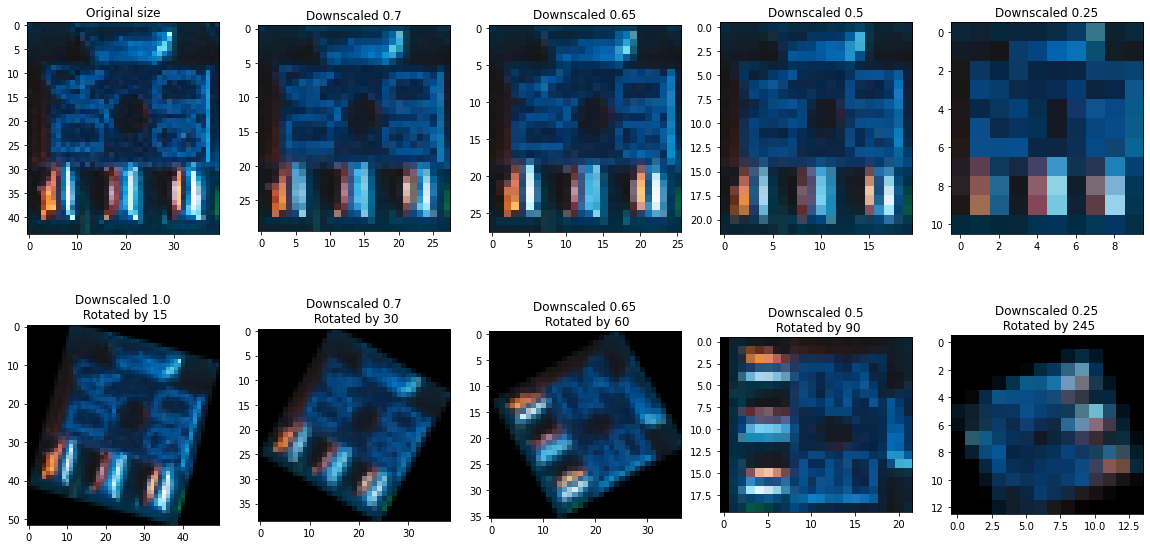

In [3]:
import imutils

template3 = templates[2]

downscale_values = [100/100, 70/100, 65/100, 50/100, 25/100]
rotation_degrees = [15, 30, 60, 90, 245]
i = 0
resized_list = []
rotated_list = []
fig4 = plt.figure(figsize=(20, 10))
for down,rot in zip(downscale_values,rotation_degrees):
    i+=1
    temp3 = template3.copy()
    width = int(temp3.shape[1] * down)
    height = int(temp3.shape[0] * down)
    dim = (width, height)
    resized = cv2.resize(temp3, dim)
    resized_list.append(resized)
    
    fig4.add_subplot(2, 5, i)
    plt.imshow(resized)
        
    plt.title("Downscaled "+str(down))
    if i == 1 :
        plt.title("Original size")
    
    
    rotated = imutils.rotate_bound(resized,rot)
    rotated_list.append(rotated)
    
    fig4.add_subplot(2, 5, i+5)
    plt.imshow(rotated)
    plt.title("Downscaled "+str(down) +"\n Rotated by " +str(rot))

        

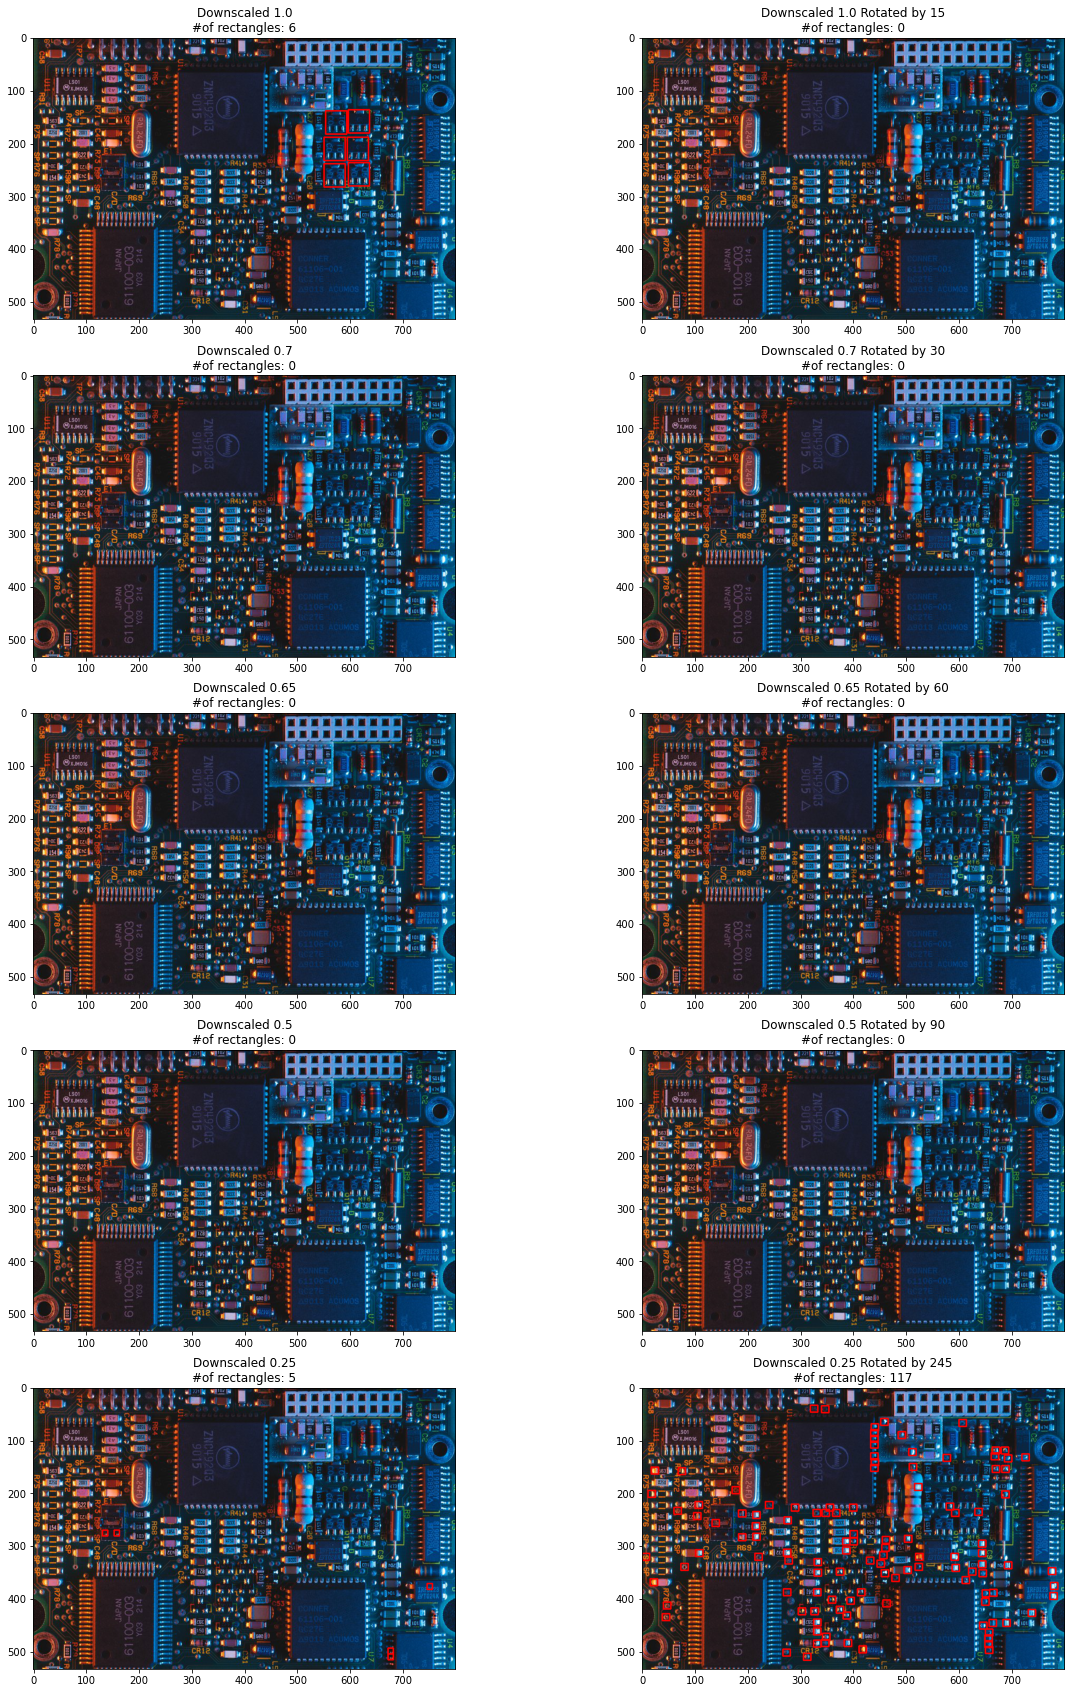

In [4]:
def findMatch(image,template,threshold = 0.58,iou_th = 0.5,color = (255,0,0)):
    
    image_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    template = cv2.cvtColor(template,cv2.COLOR_RGB2GRAY)
    
    matches = cv2.matchTemplate(image_gray,template,cv2.TM_CCOEFF_NORMED)

    locations = np.where(matches >= threshold)

    height, width = template.shape
    
    #top-left corners
    y1 = np.array(locations[0])
    x1 = np.array(locations[1])
    #bottom-right corners
    x2 = x1 + width
    y2 = y1 + height

    scores = matches[matches > threshold]

    #sorting the scores with the indexes to make sure that the first valid window has the biggest score
    scores_sorted_idxs =np.argsort(scores)[::-1] 
    valid_windows = []
    for i in scores_sorted_idxs:
        overlapped = False
        for j in valid_windows:
            #coordinates of the intersection area
            inter_x1 = max(x1[i],x1[j])
            inter_y1 = max(y1[i],y1[j])
            inter_x2 = min(x2[i],x2[j])
            inter_y2 = min(y2[i],y2[j])

            inter_width = inter_x2-inter_x1
            inter_height = inter_y2-inter_y1

            if not(inter_width <= 0 or inter_height <= 0):
                #iou calculation
                overlapped_area = inter_width*inter_height
                iou = overlapped_area / (2*width*height-overlapped_area)
                if iou > iou_th :
                    overlapped = True

        if not overlapped: #if there is no overlap, the window is valid
            valid_windows.append(i)
            
    numOfRec = len(valid_windows)       
    draw_rec = image.copy()
    
    for index in valid_windows:
        cv2.rectangle(draw_rec,(x1[index],y1[index]),(x2[index],y2[index]),color,2)

    return draw_rec, numOfRec
                        
i=0
fig5 = plt.figure(figsize=(20, 30))
for t1,t2 in zip(resized_list, rotated_list):
    i+=1
    result,numOfRec = findMatch(image,t1)
    
    
    fig5.add_subplot(5, 2, 2*i-1)
    plt.imshow(result)
    plt.title("Downscaled "+str(downscale_values[i-1])+"\n#of rectangles: " + str(numOfRec))
    
    result, numOfRec = findMatch(image,t2)
    fig5.add_subplot(5, 2, 2*i)
    plt.imshow(result)
    plt.title("Downscaled "+str(downscale_values[i-1]) + " Rotated by "+str(rotation_degrees[i-1]) + "\n#of rectangles: "+str(numOfRec))

plt.show()
    

From this question, I observe that it is almost impossible to correctly obtain the windows when we downscale the image or rotate the image. Even we downscale or rotate with respectively small values, matchTemplate function failed. When I increase the downscale value and rotation degree heavily, number of windows increased tremendously (last image). As a result, even with a slight change in the image, directly affects the accuracy of the result. This situation causes image processing to be harder than expected in real life. 

___